# Introduction

Data Proposals Simon: 

https://networkrepository.com/soc-dolphins.php

In [20]:
# Load Libraries 
import pandas as pd
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
matrix = scipy.io.mmread("data/soc-dolphins/soc-dolphins.mtx")

# Convert to a NetworkX graph (since it's a social network)
G = nx.Graph(matrix)

Number of nodes: 62
Number of edges: 159


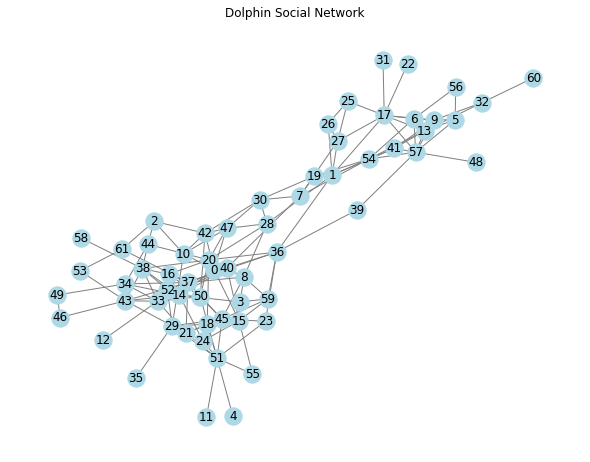

In [22]:
# Basic Information
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Visualize the Graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300)
plt.title("Dolphin Social Network")
plt.show()

In [37]:
matrix = scipy.io.mmread("data/bio-diseasome/bio-diseasome.mtx")

# Convert to a NetworkX graph (since it's a social network)
G = nx.Graph(matrix)

ValueError: source is not in Matrix Market format

In [30]:
G = nx.read_graphml('data/london_tube/tubeDLR.graphml')
G


In [32]:
print("Graph Properties:")
print("Nodes:", G.nodes(data=True))  # Prints nodes with their attributes
print("Edges:", G.edges(data=True))  # Prints edges with their attributes


Graph Properties:
Nodes: [('271', {'label': 'Acton Town', 'stationReference': 'Acton_Town_tube_station', 'longitude': '-0.28', 'latitude': '51.5028', 'displayName': 'Acton Town', 'In-Degree': 5, 'Out-Degree': 5, 'Degree': 5, 'latitude_copy': 51.5028, 'longitude_copy': -0.28, 'PageRank': 0.005566113513722363, 'Eccentricity': 26.0, 'Closeness Centrality': 11.57328990228013, 'Betweenness Centrality': 5148.9344668489375, 'Clustering Coefficient': 0.2, 'Number of triangles': 2, 'Eigenvector Centrality': 0.35874062244548194, 'size': 11.5, 'r': 233, 'g': 105, 'b': 66, 'x': -561.82874, 'y': -203.83363}), ('272', {'label': 'Aldgate', 'stationReference': 'Aldgate_tube_station', 'longitude': '-0.076', 'latitude': '51.514', 'displayName': 'Aldgate', 'In-Degree': 2, 'Out-Degree': 2, 'Degree': 2, 'latitude_copy': 51.514, 'longitude_copy': -0.076, 'PageRank': 0.0023103018182151253, 'Eccentricity': 23.0, 'Closeness Centrality': 10.429967426710098, 'Betweenness Centrality': 6.133333333333334, 'Clusteri

In [44]:
G.edges(data=True)

EdgeDataView([('271', '317', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'District_line'}), ('271', '332', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('271', '365', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('271', '474', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('271', '502', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('272', '409', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Metropolitan_line'}), ('272', '500', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Circle_line_(London_Underground)'}), ('273', '409', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Hammersmith_%26_City_line'}), ('273', '500', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'District_line'}), ('273', '530', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 

In [40]:
len(G.edges(data=True))

370

In [42]:
G.edges(data=True)

EdgeDataView([('271', '317', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'District_line'}), ('271', '332', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('271', '365', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('271', '474', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('271', '502', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Piccadilly_line'}), ('272', '409', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Metropolitan_line'}), ('272', '500', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Circle_line_(London_Underground)'}), ('273', '409', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'Hammersmith_%26_City_line'}), ('273', '500', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 'line': 'District_line'}), ('273', '530', {'weight': 1.0, 'Neo4j Relationship Type': 'CONNECTS', 

In [43]:
node_data

,label,stationReference,longitude,latitude,displayName,In-Degree,Out-Degree,Degree,latitude_copy,longitude_copy,...,Betweenness Centrality,Clustering Coefficient,Number of triangles,Eigenvector Centrality,size,r,g,b,x,y
271,Acton Town,Acton_Town_tube_station,-0.28,51.5028,Acton Town,5,5,5,51.502800,-0.280000,...,5148.934467,0.200000,2,0.358741,11.5,233,105,66,-561.82874,-203.833630
272,Aldgate,Aldgate_tube_station,-0.076,51.514,Aldgate,2,2,2,51.514000,-0.076000,...,6.133333,0.000000,0,0.243991,7.0,253,190,153,348.30634,51.922806
273,Aldgate East,Aldgate_East_tube_station,-0.0722,51.5152,Aldgate East,3,3,3,51.515200,-0.072200,...,5994.494677,0.000000,0,0.320489,8.5,252,165,121,397.10132,41.687120
274,Alperton,Alperton_tube_station,-0.2997,51.5408,Alperton,2,2,2,51.540800,-0.299700,...,278.266667,0.000000,0,0.040860,7.0,253,190,153,-605.07794,-36.795143
275,Amersham,Amersham_station,-0.607,51.674,Amersham,1,0,1,51.674000,-0.607000,...,0.000000,0.000000,0,0.026905,5.5,253,215,185,-499.29178,278.691500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,Tower Gateway,Tower_Gateway_DLR_station,-0.0746,51.5104,Tower Gateway,1,0,1,51.510400,-0.074600,...,0.000000,0.000000,0,0.067216,5.5,253,215,185,357.99180,4.821801
576,West India Quay,West_India_Quay_DLR_station,-0.0203,51.5067,West India Quay,3,3,3,51.506700,-0.020300,...,3256.000000,0.333333,1,0.131240,8.5,252,165,121,560.73110,-180.040080
577,West Silvertown,West_Silvertown_DLR_station,0.0225,51.502778,West Silvertown,1,2,2,51.502778,0.022500,...,1212.000000,0.000000,0,0.149535,7.0,253,190,153,661.34564,-96.736130
578,Westferry,Westferry_DLR_station,-0.026697,51.509372,Westferry,3,3,3,51.509372,-0.026697,...,3830.519444,0.333333,1,0.140233,8.5,252,165,121,521.15170,-144.291800


In [41]:
node_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
edges_data = pd.DataFrame.from_dict(dict(G.edges(data=True)), orient='index')

# Display the table
print(edges_data)

ValueError: dictionary update sequence element #0 has length 3; 2 is required

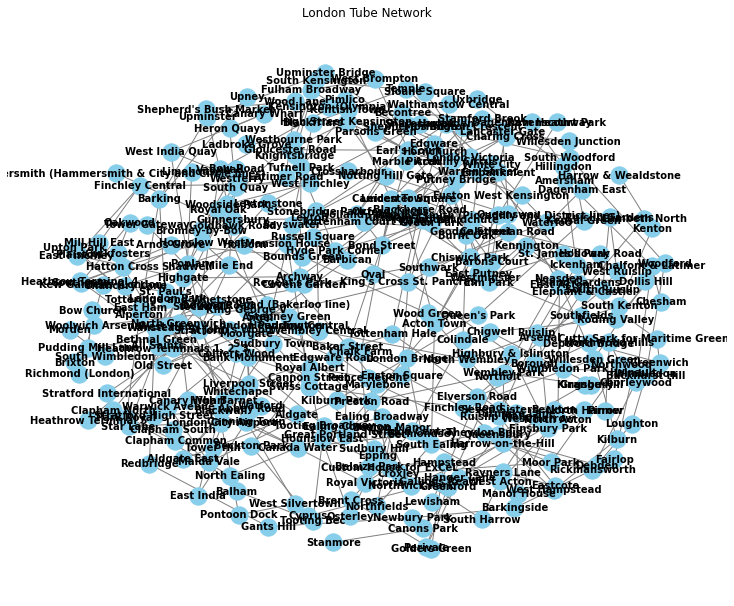

In [36]:
# Extract labels from node data (assuming the label column exists)
labels = nx.get_node_attributes(G, 'label')

# Create the plot
plt.figure(figsize=(10, 8))

# Use spring_layout with larger spacing between nodes
pos = nx.spring_layout(G, seed=42, k=0.3)  # Adjust k for node spacing (default k=0.1)

# Draw the network with the station names as labels
nx.draw(G, pos, with_labels=True, labels=labels, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# Display the plot
plt.title("London Tube Network")
plt.show()

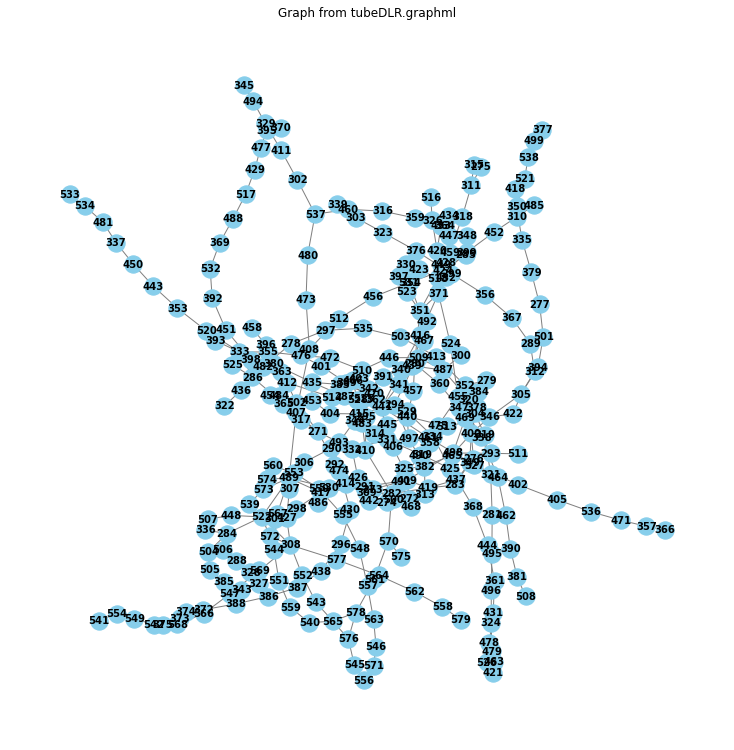

In [31]:
# Plot the graph
plt.figure(figsize=(10, 10))  # Set figure size
nx.draw(G, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Graph from tubeDLR.graphml")
plt.show()


In [ ]:
# Load Network
edges = pd.read_csv("data/eco-stmarks/eco-stmarks.edges", delim_whitespace=True, header=None, names=["source", "target", "weight"])

/var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/ipykernel_26463/249108742.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  edges = pd.read_csv("data/soc-dolphins/soc-dolphins.mtx", delim_whitespace=True, header=None, names=["source", "target", "weight"])


ParserError: Error tokenizing data. C error: Expected 5 fields in line 3, saw 7


In [18]:
edges

,source,target,weight
0,52,1,28.310000
1,52,2,41.520000
2,52,3,265.030000
3,52,4,4.520000
4,52,5,169.950000
...,...,...,...
351,44,48,0.008000
352,49,6,32.250000
353,50,7,1.600000
354,50,51,6.498001


Number of nodes: 54
Number of edges: 353
Average degree: 13.074074074074074


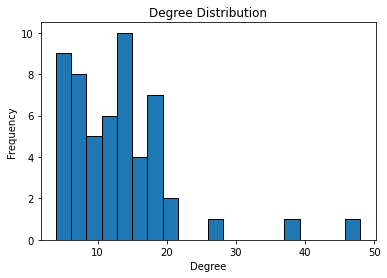

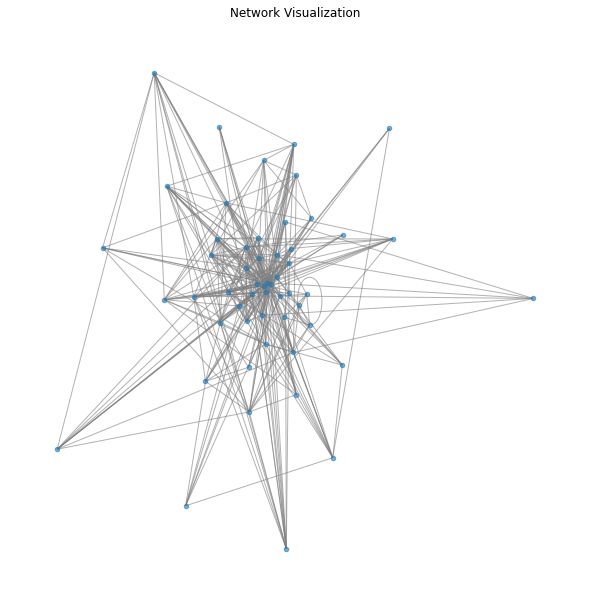

In [17]:
# Create a graph
G = nx.Graph()
G.add_weighted_edges_from(edges.values)

# Basic EDA
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())

# Plot the degree distribution
degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=20, edgecolor="black")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

# Draw the network
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=20, alpha=0.6, edge_color="gray")
plt.title("Network Visualization")
plt.show()
